In [9]:
# Predicting House Prices: A Regression Example

In [10]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [11]:
# Normalizing the Data

# It would be problematic to feed values that all take wildly different ranges into a neural network. The network
# might be able to automatically adapt to such heterogenous data (a column in the input data matrix), you subtract 
# the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a 
# unit standard deviation.

mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std



In [12]:
# Building your network 

# Build a small network, due to small sample pool
# Num_layers: 4 layers
#             Note the last layer does not use sigmoid, because it is free to predict values in any range.
# Optimizer: rmsprop, like normal
# Loss: Mean Squared Error (MSE), the square of the difference between the predictions and the targets. This 
#       is fairly common in regression problems.
# Metric: Mean Absolute Error, the absolute value of the difference between the predictions and the targets.

from keras import models
from keras import layers

def build_model():

    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model



In [13]:
# Validating your approach using K-fold validation

# Since we have so few data points, the validation set would end up being very small. This means that 
# the validation scores might change a lot depending on which data points you chose to use for validation 
# and which you chose for training. This would prevent reliable evaluation of the model.

# The best practice to use is K-Fold cross-validation, which splits the available data into K partitions
# (typically K=4 or 5), instantiating K identical models, and training each one on K-1 partitions while
# evaluating on the remaining partition

import numpy as np

num_partitions = 4
num_val_samples = len(train_data) // num_partitions
num_epochs = 500
all_mae_histories = []

for i in range(num_partitions):
    print('Processsing Fold #', i+1)
    
    # Preapres validation data for given partition
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Create train_data set for model
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    
    # Create train_targets set for model
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    
    # Instantiate new model
    model = build_model()
    
    # Train model and store output in History object
    history = model.fit(partial_train_data, 
              partial_train_targets, 
              epochs=num_epochs, 
              batch_size=1,
              validation_data=(val_data, val_targets),
              verbose=0)

    # Retrieve Mean Absolute Error for each epoch object from History object
    mae_history = history.history['val_mean_absolute_error']
    
    # Add Mean Absolute Error of model to all_scores list
    all_mae_histories.append(mae_history)
    
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# Compute average of per-epoch MAE scores for all folds
# average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Processsing Fold # 1
Processsing Fold # 2
Processsing Fold # 3
Processsing Fold # 4


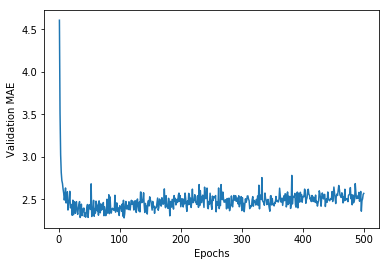

In [14]:
# Plot validation scores including first 10 data points

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

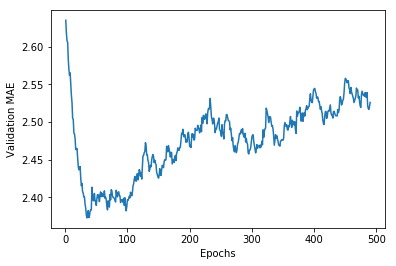

In [52]:
# Plot validation scores ecluding the first 10 data points and applying an exponential moving average

# From the plot, the model stops improving after 80-100 epochs. Start fiddling with the number of epochs

def smooth_curve(points, factor):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

plt.clf()

smooth_mae_history = smooth_curve(average_mae_history[10:], 0.9)

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [53]:
# Compile the model with 80-100 epochs

model = build_model()
model.fit(train_data, train_targets, epochs=90, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 3ms/step
2.639264658385632
